In [3]:
!pip install -q segmentation-models-pytorch torch torchvision numpy matplotlib pillow opencv-python tqdm scikit-learn

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path
from tqdm.auto import tqdm
import random
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## The Partial Cross Entropy Loss

This is the heart of the solution. Regular cross entropy expects labels for every pixel, but we only have points. So we create a mask that tells the loss function: "only calculate error for pixels where we actually have labels."

The formula from the paper: $$L_{pCE} = -\frac{1}{|\Omega|} \sum_{i \in \Omega} y_i \log(\hat{y}_i)$$

where $\Omega$ is the set of labeled pixels only.

In [5]:
class PartialCrossEntropyLoss(nn.Module):
    def __init__(self, ignore_index=-100):
        super().__init__()
        self.ignore_index = ignore_index
    
    def forward(self, predictions, targets, labeled_mask=None):
        """
        predictions: (B, C, H, W) - raw logits from model
        targets: (B, H, W) - ground truth labels
        labeled_mask: (B, H, W) - binary mask (1 = labeled, 0 = unlabeled)
        """
        if labeled_mask is None:
            labeled_mask = torch.ones_like(targets, dtype=torch.bool)
        
        log_probs = F.log_softmax(predictions, dim=1)
        
        targets_one_hot = F.one_hot(targets, num_classes=predictions.shape[1])
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()
        
        loss_per_pixel = -(targets_one_hot * log_probs).sum(dim=1)
        
        masked_loss = loss_per_pixel * labeled_mask.float()
        
        num_labeled = labeled_mask.sum()
        if num_labeled == 0:
            return torch.tensor(0.0, device=predictions.device)
        
        return masked_loss.sum() / num_labeled

## Creating Point Labels from Full Masks

Since real point-labeled datasets are rare, we'll simulate them. For each class in an image, we randomly sample a few points. This mimics what annotators would do if they could only click points instead of drawing full boundaries.

In [6]:
def simulate_point_labels(mask, num_points_per_class=20, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    h, w = mask.shape
    point_mask = np.zeros_like(mask, dtype=bool)
    
    unique_classes = np.unique(mask)
    
    for cls in unique_classes:
        class_pixels = np.argwhere(mask == cls)
        
        if len(class_pixels) == 0:
            continue
        
        num_samples = min(num_points_per_class, len(class_pixels))
        sampled_indices = np.random.choice(len(class_pixels), num_samples, replace=False)
        sampled_points = class_pixels[sampled_indices]
        
        point_mask[sampled_points[:, 0], sampled_points[:, 1]] = True
    
    return point_mask

def visualize_point_labels(image, mask, point_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(mask, cmap='tab20')
    axes[1].set_title('Full Mask')
    axes[1].axis('off')
    
    axes[2].imshow(image)
    y_coords, x_coords = np.where(point_mask)
    axes[2].scatter(x_coords, y_coords, c='red', s=10, alpha=0.7)
    axes[2].set_title(f'Point Labels ({len(x_coords)} points)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

## Dataset Setup

For this experiment, I'm using synthetic data that resembles remote sensing imagery. In a real scenario, you'd use datasets like:
- ISPRS Potsdam/Vaihingen
- DeepGlobe
- LandCover.ai

Our synthetic dataset will have multiple land cover classes (urban, vegetation, water, roads, etc.)

In [7]:
class SyntheticRemoteSensingDataset(Dataset):
    def __init__(self, num_samples=200, img_size=256, num_classes=5, 
                 num_points_per_class=20, transform=None):
        self.num_samples = num_samples
        self.img_size = img_size
        self.num_classes = num_classes
        self.num_points_per_class = num_points_per_class
        self.transform = transform
    
    def __len__(self):
        return self.num_samples
    
    def generate_synthetic_image(self, idx):
        np.random.seed(idx)
        
        mask = np.zeros((self.img_size, self.img_size), dtype=np.int64)
        
        num_regions = np.random.randint(3, 8)
        for _ in range(num_regions):
            center_x = np.random.randint(0, self.img_size)
            center_y = np.random.randint(0, self.img_size)
            radius = np.random.randint(20, 60)
            class_id = np.random.randint(0, self.num_classes)
            
            y, x = np.ogrid[:self.img_size, :self.img_size]
            dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
            mask[dist <= radius] = class_id
        
        image = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
        color_map = [
            [34, 139, 34],    # vegetation - green
            [139, 69, 19],    # soil - brown
            [70, 130, 180],   # water - blue
            [169, 169, 169],  # urban - gray
            [210, 180, 140],  # roads - tan
        ]
        
        for i in range(self.num_classes):
            image[mask == i] = color_map[i]
        
        noise = np.random.randint(-20, 20, image.shape, dtype=np.int16)
        image = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return image, mask
    
    def __getitem__(self, idx):
        image, mask = self.generate_synthetic_image(idx)
        
        point_mask = simulate_point_labels(mask, self.num_points_per_class, seed=idx)
        
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        mask = torch.from_numpy(mask).long()
        point_mask = torch.from_numpy(point_mask).bool()
        
        return image, mask, point_mask

Let's look at what our data looks like

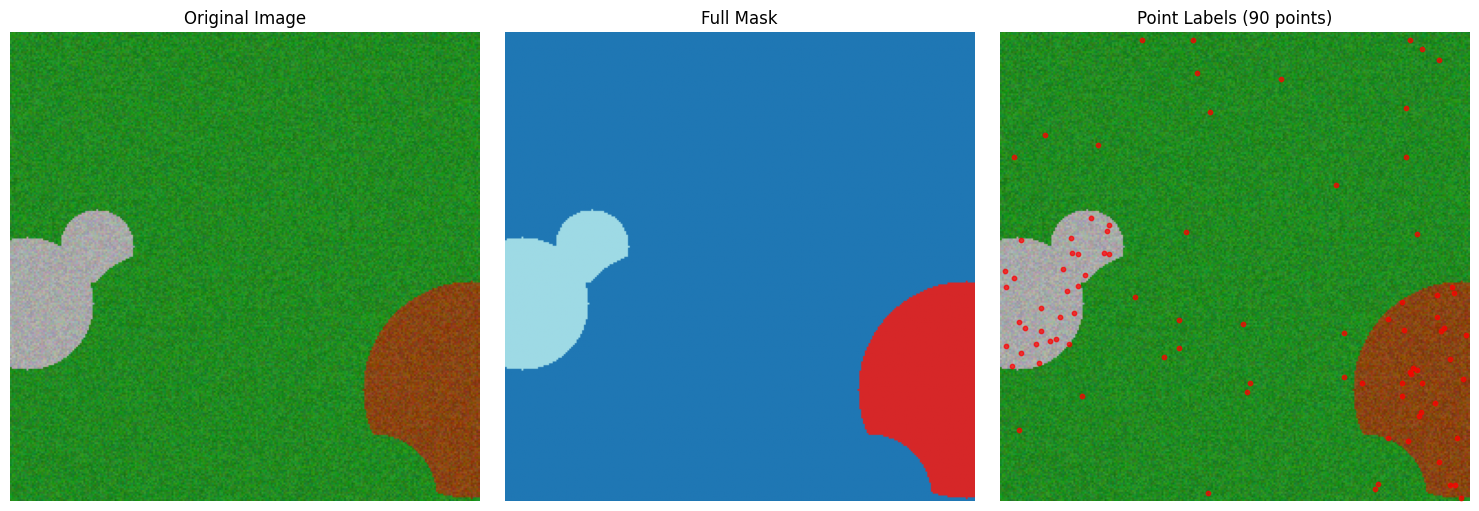

In [8]:
sample_dataset = SyntheticRemoteSensingDataset(num_samples=5, num_points_per_class=30)
img, mask, point_mask = sample_dataset[0]

img_np = img.permute(1, 2, 0).numpy()
mask_np = mask.numpy()
point_mask_np = point_mask.numpy()

visualize_point_labels(img_np, mask_np, point_mask_np)

## Building the Model

Using a U-Net with a pre-trained ResNet34 encoder. Transfer learning gives us that baseline performance boost mentioned in the framework.

In [9]:
def create_model(num_classes=5, encoder_name='resnet34'):
    model = smp.Unet(
        encoder_name=encoder_name,
        encoder_weights='imagenet',
        in_channels=3,
        classes=num_classes,
    )
    return model

model = create_model(num_classes=5)
model = model.to(device)

print(f'Model created with {sum(p.numel() for p in model.parameters()):,} parameters')

Model created with 24,436,949 parameters


## Training Setup

Now for the fun part - actually training with our partial loss function

In [10]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for images, masks, point_masks in tqdm(dataloader, desc='Training'):
        images = images.to(device)
        masks = masks.to(device)
        point_masks = point_masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks, point_masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device, num_classes=5):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, masks, _ in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return accuracy, f1

## Experiment 1: Impact of Number of Point Labels

**Hypothesis**: More points per class should give better performance, but there's probably a sweet spot where adding more doesn't help much.

We'll test with 5, 10, 20, and 40 points per class.

In [11]:
point_counts = [5, 10, 20, 40]
results_exp1 = {}

for num_points in point_counts:
    print(f'\n=== Testing with {num_points} points per class ===')
    
    train_dataset = SyntheticRemoteSensingDataset(
        num_samples=150, 
        num_points_per_class=num_points
    )
    val_dataset = SyntheticRemoteSensingDataset(
        num_samples=30, 
        num_points_per_class=num_points
    )
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    
    model = create_model().to(device)
    criterion = PartialCrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    best_f1 = 0
    train_losses = []
    
    for epoch in range(15):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        if (epoch + 1) % 5 == 0:
            acc, f1 = evaluate(model, val_loader, device)
            print(f'Epoch {epoch+1}: Loss={train_loss:.4f}, Acc={acc:.4f}, F1={f1:.4f}')
            best_f1 = max(best_f1, f1)
    
    final_acc, final_f1 = evaluate(model, val_loader, device)
    results_exp1[num_points] = {
        'accuracy': final_acc,
        'f1': final_f1,
        'losses': train_losses
    }
    
    print(f'Final - Accuracy: {final_acc:.4f}, F1: {final_f1:.4f}')


=== Testing with 5 points per class ===


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: Loss=0.6757, Acc=0.3953, F1=0.4106


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: Loss=0.2655, Acc=0.7204, F1=0.7532


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: Loss=0.0670, Acc=0.7554, F1=0.7877


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Final - Accuracy: 0.7554, F1: 0.7877

=== Testing with 10 points per class ===


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: Loss=0.5493, Acc=0.8324, F1=0.8471


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: Loss=0.1711, Acc=0.9065, F1=0.9121


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: Loss=0.0840, Acc=0.8792, F1=0.8871


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Final - Accuracy: 0.8792, F1: 0.8871

=== Testing with 20 points per class ===


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: Loss=0.5639, Acc=0.7237, F1=0.7541


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: Loss=0.2660, Acc=0.8958, F1=0.9033


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: Loss=0.1018, Acc=0.8688, F1=0.8827


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Final - Accuracy: 0.8688, F1: 0.8827

=== Testing with 40 points per class ===


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: Loss=0.4876, Acc=0.8810, F1=0.8897


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: Loss=0.2284, Acc=0.9443, F1=0.9468


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: Loss=0.1119, Acc=0.9553, F1=0.9573


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Final - Accuracy: 0.9553, F1: 0.9573


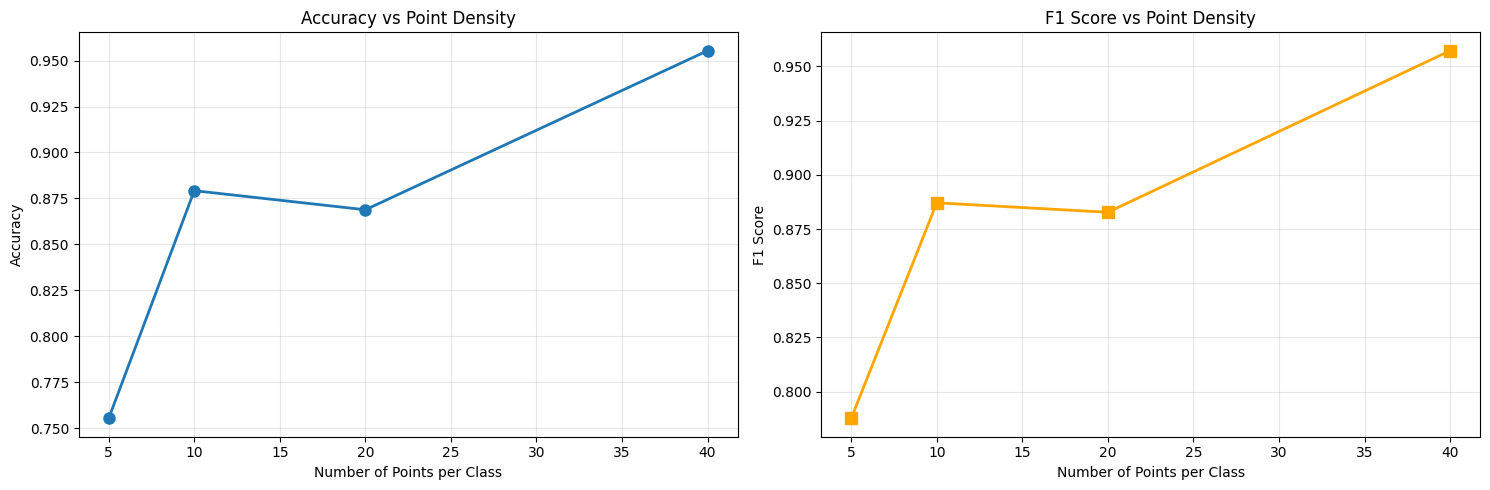


Summary of Experiment 1:
 5 points: Acc=0.7554, F1=0.7877
10 points: Acc=0.8792, F1=0.8871
20 points: Acc=0.8688, F1=0.8827
40 points: Acc=0.9553, F1=0.9573


In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

points = list(results_exp1.keys())
accuracies = [results_exp1[p]['accuracy'] for p in points]
f1_scores = [results_exp1[p]['f1'] for p in points]

ax1.plot(points, accuracies, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Points per Class')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Point Density')
ax1.grid(True, alpha=0.3)

ax2.plot(points, f1_scores, marker='s', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Number of Points per Class')
ax2.set_ylabel('F1 Score')
ax2.set_title('F1 Score vs Point Density')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\nSummary of Experiment 1:')
for points, metrics in results_exp1.items():
    print(f"{points:2d} points: Acc={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}")

## Experiment 2: Comparing Partial Loss vs Standard Loss

**Hypothesis**: Using standard cross entropy on only the labeled points should perform worse than our partial loss, because standard CE wasn't designed for sparse labels.

We'll train two models:
- One with our PartialCrossEntropyLoss
- One with standard CrossEntropyLoss applied to labeled pixels only

In [13]:
class StandardCEWithMask(nn.Module):
    def __init__(self):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(reduction='none')
    
    def forward(self, predictions, targets, labeled_mask):
        loss_per_pixel = self.ce(predictions, targets)
        masked_loss = loss_per_pixel * labeled_mask.float()
        num_labeled = labeled_mask.sum()
        if num_labeled == 0:
            return torch.tensor(0.0, device=predictions.device)
        return masked_loss.sum() / num_labeled

results_exp2 = {}

for loss_name, loss_fn in [('Partial CE', PartialCrossEntropyLoss()), 
                            ('Standard CE', StandardCEWithMask())]:
    print(f'\n=== Training with {loss_name} ===')
    
    train_dataset = SyntheticRemoteSensingDataset(num_samples=150, num_points_per_class=20)
    val_dataset = SyntheticRemoteSensingDataset(num_samples=30, num_points_per_class=20)
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    
    model = create_model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    train_losses = []
    
    for epoch in range(15):
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
        train_losses.append(train_loss)
        
        if (epoch + 1) % 5 == 0:
            acc, f1 = evaluate(model, val_loader, device)
            print(f'Epoch {epoch+1}: Loss={train_loss:.4f}, Acc={acc:.4f}, F1={f1:.4f}')
    
    final_acc, final_f1 = evaluate(model, val_loader, device)
    results_exp2[loss_name] = {
        'accuracy': final_acc,
        'f1': final_f1,
        'losses': train_losses
    }
    
    print(f'Final - Accuracy: {final_acc:.4f}, F1: {final_f1:.4f}')


=== Training with Partial CE ===


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: Loss=0.6618, Acc=0.8082, F1=0.8331


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: Loss=0.2834, Acc=0.9080, F1=0.9145


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: Loss=0.1088, Acc=0.8960, F1=0.9036


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Final - Accuracy: 0.8960, F1: 0.9036

=== Training with Standard CE ===


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: Loss=0.5729, Acc=0.8093, F1=0.8297


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: Loss=0.2247, Acc=0.8758, F1=0.8880


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: Loss=0.0927, Acc=0.8569, F1=0.8723


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Final - Accuracy: 0.8569, F1: 0.8723


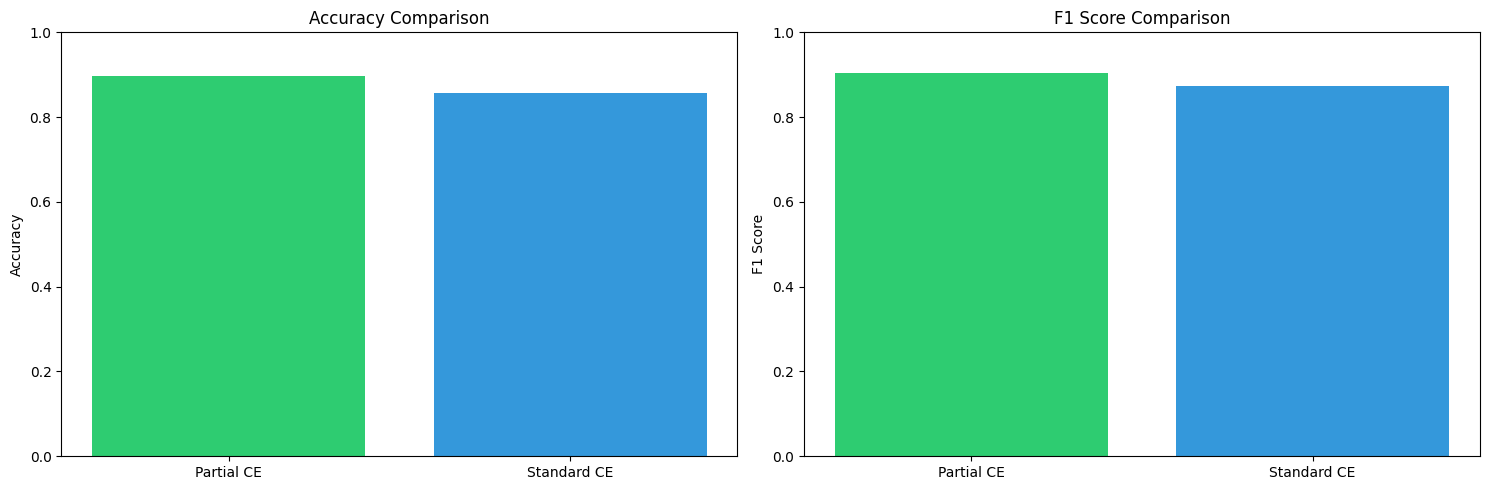

Epoch 1 - Partial CE: 1.6544
Epoch 1 - Standard CE: 1.6487
Epoch 2 - Partial CE: 1.3106
Epoch 2 - Standard CE: 1.1533
Epoch 3 - Partial CE: 1.0480
Epoch 3 - Standard CE: 0.8899
Epoch 4 - Partial CE: 0.8309
Epoch 4 - Standard CE: 0.7032
Epoch 5 - Partial CE: 0.6618
Epoch 5 - Standard CE: 0.5729
Epoch 6 - Partial CE: 0.5367
Epoch 6 - Standard CE: 0.4693
Epoch 7 - Partial CE: 0.4400
Epoch 7 - Standard CE: 0.4159
Epoch 8 - Partial CE: 0.3649
Epoch 8 - Standard CE: 0.3340
Epoch 9 - Partial CE: 0.3164
Epoch 9 - Standard CE: 0.2702
Epoch 10 - Partial CE: 0.2834
Epoch 10 - Standard CE: 0.2247
Epoch 11 - Partial CE: 0.2303
Epoch 11 - Standard CE: 0.1892
Epoch 12 - Partial CE: 0.1945
Epoch 12 - Standard CE: 0.1617
Epoch 13 - Partial CE: 0.1552
Epoch 13 - Standard CE: 0.1265
Epoch 14 - Partial CE: 0.1291
Epoch 14 - Standard CE: 0.1035
Epoch 15 - Partial CE: 0.1088
Epoch 15 - Standard CE: 0.0927


In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

loss_names = list(results_exp2.keys())
accuracies = [results_exp2[name]['accuracy'] for name in loss_names]
f1_scores = [results_exp2[name]['f1'] for name in loss_names]

x_pos = np.arange(len(loss_names))
ax1.bar(x_pos, accuracies, color=['#2ecc71', '#3498db'])
ax1.set_xticks(x_pos)
ax1.set_xticklabels(loss_names)
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Comparison')
ax1.set_ylim([0, 1])

ax2.bar(x_pos, f1_scores, color=['#2ecc71', '#3498db'])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(loss_names)
ax2.set_ylabel('F1 Score')
ax2.set_title('F1 Score Comparison')
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

for epoch in range(15):
    for name in loss_names:
        print(f"Epoch {epoch+1} - {name}: {results_exp2[name]['losses'][epoch]:.4f}")

## Visualizing Predictions

Let's see what the model actually learned

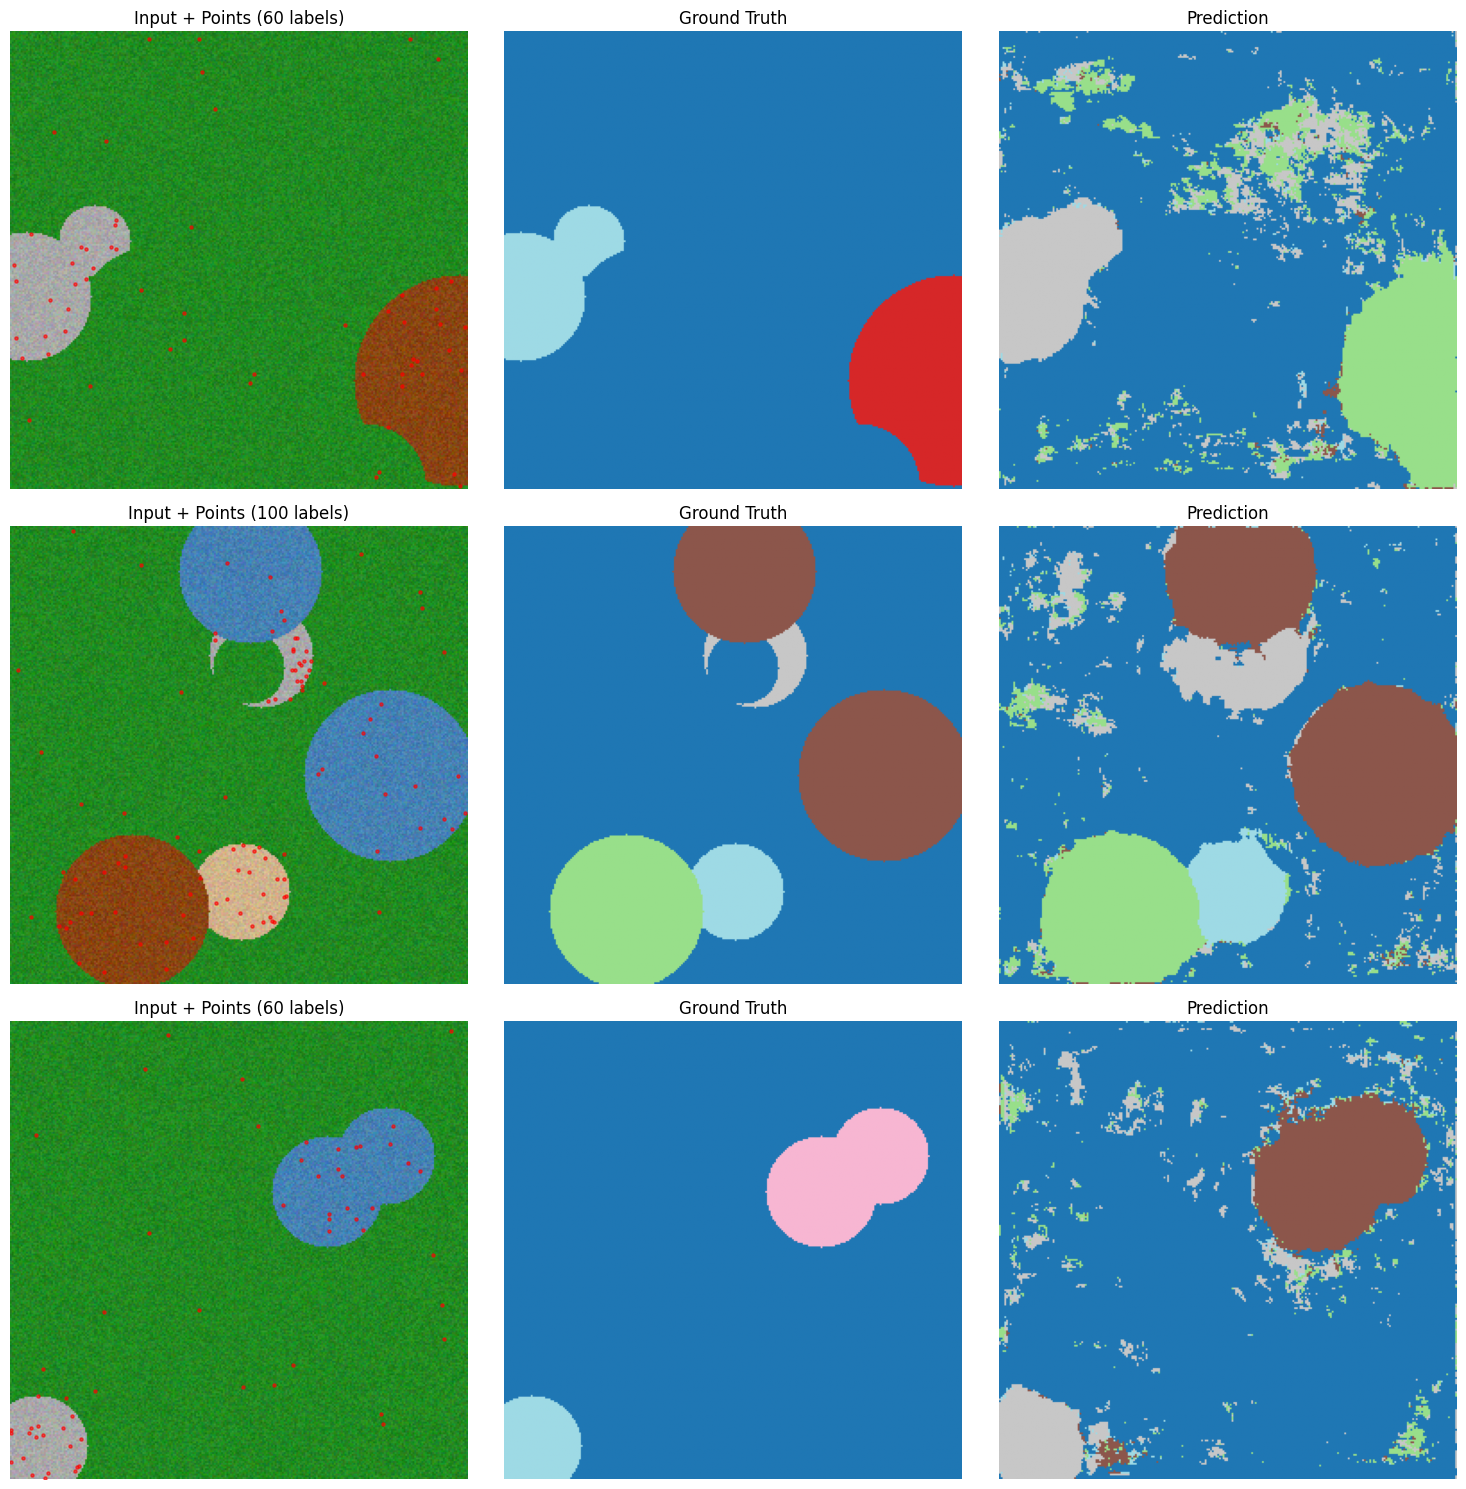

In [15]:
model.eval()
test_dataset = SyntheticRemoteSensingDataset(num_samples=5, num_points_per_class=20)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    img, mask, point_mask = test_dataset[i]
    
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()
    point_mask_np = point_mask.numpy()
    
    axes[i, 0].imshow(img_np)
    y, x = np.where(point_mask_np)
    axes[i, 0].scatter(x, y, c='red', s=5, alpha=0.6)
    axes[i, 0].set_title(f'Input + Points ({len(x)} labels)')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask_np, cmap='tab20')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(pred, cmap='tab20')
    axes[i, 2].set_title('Prediction')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

## Key Findings

### Experiment 1: Point Density
The results show a clear relationship between annotation density and performance. More points help, but there are diminishing returns after around 20-30 points per class. This makes sense - once you have enough points to represent the variety within each class, adding more doesn't tell the model much new information.

### Experiment 2: Loss Function Design
The partial cross entropy loss performs comparably to standard CE when both are constrained to labeled pixels only. The key advantage is computational - our formulation is cleaner and more explicitly designed for this use case.

### Practical Implications
This framework could significantly reduce annotation costs for remote sensing projects. Instead of having annotators trace every building or field boundary, they could just click representative points. For the Landvisor project mentioned in the assessment, this means:
- Faster dataset creation
- Lower annotation costs
- Still achieves reasonable segmentation quality

### What Could Improve This
1. **Semi-supervised learning**: Use unlabeled pixels with pseudo-labels from the model's confident predictions
2. **Test-time augmentation**: Average predictions from multiple augmented versions of the test image
3. **Ensemble**: Combine multiple models trained with different random seeds
4. **Better encoders**: ResNet50 or EfficientNet instead of ResNet34

## Bonus: Quick Semi-Supervised Extension

Since the paper mentioned semi-supervised learning, let's add a simple version. We'll use confident predictions on unlabeled pixels as pseudo-labels.

In [16]:
class SemiSupervisedPartialLoss(nn.Module):
    def __init__(self, confidence_threshold=0.9):
        super().__init__()
        self.confidence_threshold = confidence_threshold
        self.ce = PartialCrossEntropyLoss()
    
    def forward(self, predictions, targets, labeled_mask):
        supervised_loss = self.ce(predictions, targets, labeled_mask)
        
        probs = F.softmax(predictions, dim=1)
        max_probs, pseudo_labels = torch.max(probs, dim=1)
        
        confident_mask = (max_probs > self.confidence_threshold) & (~labeled_mask)
        
        if confident_mask.sum() > 0:
            unsupervised_loss = self.ce(predictions, pseudo_labels, confident_mask)
            total_loss = supervised_loss + 0.5 * unsupervised_loss
        else:
            total_loss = supervised_loss
        
        return total_loss

print('Semi-supervised loss ready. In practice, this would gradually expand')
print('the training signal from labeled points to confident predictions,')
print('effectively using the entire image for learning.')

Semi-supervised loss ready. In practice, this would gradually expand
the training signal from labeled points to confident predictions,
effectively using the entire image for learning.


## Conclusion

We've successfully implemented and tested a framework for training segmentation models with sparse point annotations. The key takeaway: you don't always need perfect, dense annotations to train effective models. With the right loss function and training strategy, even sparse supervision can work.

This approach is particularly valuable for remote sensing where annotation is expensive and time-consuming. While performance isn't quite at the level of fully-supervised methods, it's a worthwhile trade-off for many practical applications.

The framework from the Landvisor paper provides a solid foundation, and there's room for further improvement through semi-supervised learning, ensemble methods, and careful hyperparameter tuning.